In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
import seaborn as sns
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from pylab import rcParams
import itertools
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from pandas import Series
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tools.eval_measures import rmse
from tensorflow.keras.models import save_model
import warnings
warnings.filterwarnings("ignore")

<ipython-input-1-6b682b51bcc0>:16: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
data=pd.read_excel(r"../SAMSUNG/Me.xlsx")

In [3]:
furniture= data.groupby('Order Date')['Quantity'].sum().reset_index()
furniture

,Order Date,Quantity
0,2014-01-06,9
1,2014-01-07,3
2,2014-01-10,1
3,2014-01-11,2
4,2014-01-13,9
...,...,...
1983,2020-12-27,13
1984,2020-12-28,4
1985,2020-12-29,98
1986,2020-12-30,68


In [4]:
furniture = data.set_index('Order Date')

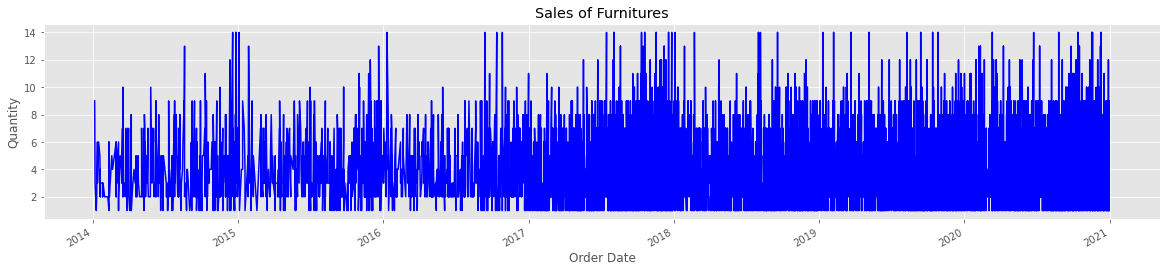

In [5]:
ax= furniture['Quantity'].plot(color='blue',figsize=(20,4))
ax.set_xlabel("Order Date")
ax.set_ylabel('Quantity')
ax.set_title("Sales of Furnitures")
plt.show()

In [6]:
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    performance_data= {'MSE':round(mse, 2),
                      'RMSE':round(np.sqrt(mse), 2),
                       'MAPE':round(mape, 2)
                      }
    return performance_data

def performance2(y_true, y_pred): 
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print(' The MSE of forecasts is {}'.format(round(mse, 2))+
                  '\n The RMSE of forecasts is {}'.format(round(np.sqrt(mse), 2))+
                  '\n The MAPE of forecasts is {}'.format(round(mape, 2))))

In [7]:
df = furniture['Quantity'].resample('MS').sum()

In [8]:
train, test = np.array(df[:-18]), np.array(df[-18:])
train= train.reshape(-1,1)
test= test.reshape(-1,1)

In [9]:
#Scale train and test data to [-1, 1]
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [10]:
n_input = 18
# univariate
n_features = 1
#TimeseriesGenerator automatically transform a univariate time series dataset into a supervised learning problem.
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=10)

In [11]:
######
n=3
store2= np.zeros((18,n))
for i in range(n):
    model_stacked = Sequential()
    #In stacked LSTM, we should output a sequence rather than a single value for each input -> return_sequences=True
    model_stacked.add(LSTM(100, activation='relu', return_sequences = True, input_shape=(18, 1)))
    model_stacked.add(LSTM(100, activation='relu'))
    model_stacked.add(Dense(150, activation='relu'))
    model_stacked.add(Dense(100, activation='relu'))
    model_stacked.add(Dense(1))
    model_stacked.compile(optimizer='adam', loss='mse')
    model_stacked.fit_generator(generator,epochs=200)
    
    pred_list_s = []

    batch = train[-n_input:].reshape((1, n_input, n_features))

    for j in range(n_input):   
        pred_list_s.append(model_stacked.predict(batch)[0]) 
        batch = np.append(batch[:,1:,:],[[pred_list_s[j]]],axis=1)

    df_predict_stacked = pd.DataFrame(scaler.inverse_transform(pred_list_s),
                              index=df[-n_input:].index, columns=['Prediction'])

    
    store2[:,i]=df_predict_stacked['Prediction']
print(store2)

Epoch 1/200
5/5 [==============================] - 2s 16ms/step - loss: 0.1339
Epoch 2/200
5/5 [==============================] - 0s 15ms/step - loss: 0.0912
Epoch 3/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0470
Epoch 4/200
5/5 [==============================] - 0s 14ms/step - loss: 0.0522
Epoch 5/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0376
Epoch 6/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0385
Epoch 7/200
5/5 [==============================] - 0s 15ms/step - loss: 0.0368
Epoch 8/200
5/5 [==============================] - 0s 14ms/step - loss: 0.0366
Epoch 9/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0386
Epoch 10/200
5/5 [==============================] - 0s 14ms/step - loss: 0.0375
Epoch 11/200
5/5 [==============================] - 0s 15ms/step - loss: 0.0364
Epoch 12/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0387
Epoch 13/200
5/5 [==============================]

5/5 [==============================] - 0s 14ms/step - loss: 0.0174
Epoch 104/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0164
Epoch 105/200
5/5 [==============================] - 0s 14ms/step - loss: 0.0168
Epoch 106/200
5/5 [==============================] - 0s 14ms/step - loss: 0.0147
Epoch 107/200
5/5 [==============================] - 0s 14ms/step - loss: 0.0176
Epoch 108/200
5/5 [==============================] - 0s 14ms/step - loss: 0.0307
Epoch 109/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0163
Epoch 110/200
5/5 [==============================] - 0s 14ms/step - loss: 0.0268
Epoch 111/200
5/5 [==============================] - 0s 14ms/step - loss: 0.0198
Epoch 112/200
5/5 [==============================] - 0s 14ms/step - loss: 0.0197
Epoch 113/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0198
Epoch 114/200
5/5 [==============================] - 0s 14ms/step - loss: 0.0185
Epoch 115/200
5/5 [=======================

5/5 [==============================] - 0s 12ms/step - loss: 0.0488
Epoch 5/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0389
Epoch 6/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0413
Epoch 7/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0413
Epoch 8/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0352
Epoch 9/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0357
Epoch 10/200
5/5 [==============================] - 0s 16ms/step - loss: 0.0380
Epoch 11/200
5/5 [==============================] - 0s 14ms/step - loss: 0.0389
Epoch 12/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0354
Epoch 13/200
5/5 [==============================] - 0s 14ms/step - loss: 0.0364
Epoch 14/200
5/5 [==============================] - 0s 14ms/step - loss: 0.0386
Epoch 15/200
5/5 [==============================] - 0s 14ms/step - loss: 0.0353
Epoch 16/200
5/5 [==============================] - 0s 15m

5/5 [==============================] - 0s 13ms/step - loss: 0.0224
Epoch 107/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0299
Epoch 108/200
5/5 [==============================] - 0s 14ms/step - loss: 0.0249
Epoch 109/200
5/5 [==============================] - 0s 14ms/step - loss: 0.0222
Epoch 110/200
5/5 [==============================] - 0s 19ms/step - loss: 0.0225
Epoch 111/200
5/5 [==============================] - 0s 19ms/step - loss: 0.0176
Epoch 112/200
5/5 [==============================] - 0s 16ms/step - loss: 0.0189
Epoch 113/200
5/5 [==============================] - 0s 16ms/step - loss: 0.0191
Epoch 114/200
5/5 [==============================] - 0s 19ms/step - loss: 0.0180
Epoch 115/200
5/5 [==============================] - 0s 16ms/step - loss: 0.0171
Epoch 116/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0154
Epoch 117/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0149
Epoch 118/200
5/5 [=======================

5/5 [==============================] - 0s 14ms/step - loss: 0.0391
Epoch 7/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0364
Epoch 8/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0339
Epoch 9/200
5/5 [==============================] - 0s 14ms/step - loss: 0.0359
Epoch 10/200
5/5 [==============================] - 0s 15ms/step - loss: 0.0358
Epoch 11/200
5/5 [==============================] - 0s 14ms/step - loss: 0.0383
Epoch 12/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0353
Epoch 13/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0343
Epoch 14/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0340
Epoch 15/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0390
Epoch 16/200
5/5 [==============================] - 0s 14ms/step - loss: 0.0332
Epoch 17/200
5/5 [==============================] - 0s 15ms/step - loss: 0.0354
Epoch 18/200
5/5 [==============================] - 0s 1

5/5 [==============================] - 0s 14ms/step - loss: 0.0159
Epoch 108/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0159
Epoch 109/200
5/5 [==============================] - 0s 14ms/step - loss: 0.0135
Epoch 110/200
5/5 [==============================] - 0s 15ms/step - loss: 0.0147
Epoch 111/200
5/5 [==============================] - 0s 16ms/step - loss: 0.0168
Epoch 112/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0529
Epoch 113/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0413
Epoch 114/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0272
Epoch 115/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0210
Epoch 116/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0220
Epoch 117/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0167
Epoch 118/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0194
Epoch 119/200
5/5 [=======================

In [12]:
final_stacked2= np.zeros((store2.shape[0],1))
for i in range(store2.shape[0]):
    
    final_stacked2[i]=np.mean(store2[i,:])
final_stacked2=final_stacked2.reshape((18,))

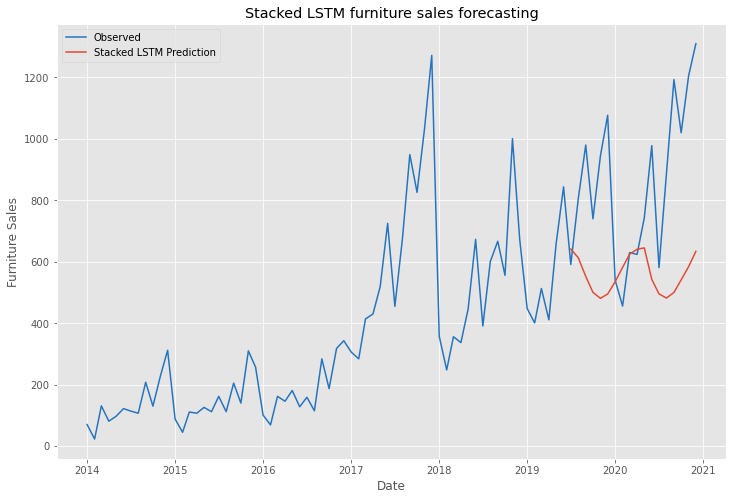

In [14]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed",color='#2574BF')
plt.plot(df[66:].index,final_stacked2,label="Stacked LSTM Prediction")
plt.title('Stacked LSTM furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()


In [15]:
data1=pd.read_csv(r"../SAMSUNG/Seo_test3round.csv")

In [16]:
furniture1= data1.groupby('Order Date')['Quantity'].sum().reset_index()
furniture1

,Order Date,Quantity
0,2014-01-11,2
1,2014-01-13,0
2,2014-01-20,3
3,2014-01-21,2
4,2014-01-26,3
...,...,...
520,2020-12-18,0
521,2020-12-20,3
522,2020-12-24,4
523,2020-12-29,5


In [17]:
furniture1 = furniture1.set_index('Order Date')

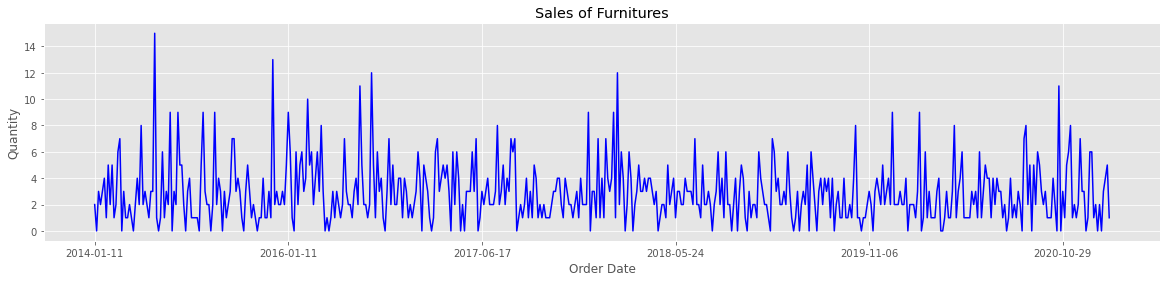

In [18]:
ax= furniture1['Quantity'].plot(color='blue',figsize=(20,4))
ax.set_xlabel("Order Date")
ax.set_ylabel('Quantity')
ax.set_title("Sales of Furnitures")
plt.show()

In [19]:
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    performance_data= {'MSE':round(mse, 2),
                      'RMSE':round(np.sqrt(mse), 2),
                       'MAPE':round(mape, 2)
                      }
    return performance_data

def performance2(y_true, y_pred): 
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print(' The MSE of forecasts is {}'.format(round(mse, 2))+
                  '\n The RMSE of forecasts is {}'.format(round(np.sqrt(mse), 2))+
                  '\n The MAPE of forecasts is {}'.format(round(mape, 2))))

In [20]:
furniture1.index

Index(['2014-01-11', '2014-01-13', '2014-01-20', '2014-01-21', '2014-01-26',
       '2014-03-11', '2014-03-15', '2014-03-19', '2014-03-21', '2014-03-25',
       ...
       '2020-12-05', '2020-12-06', '2020-12-08', '2020-12-09', '2020-12-17',
       '2020-12-18', '2020-12-20', '2020-12-24', '2020-12-29', '2020-12-30'],
      dtype='object', name='Order Date', length=525)

In [22]:
furniture1.index = pd.to_datetime(furniture1.index)
df1 = furniture1['Quantity'].resample('MS').sum()

In [23]:
df1

Order Date
2014-01-01    10
2014-02-01     0
2014-03-01    17
2014-04-01     3
2014-05-01    13
              ..
2020-08-01    21
2020-09-01    42
2020-10-01    28
2020-11-01    33
2020-12-01    31
Freq: MS, Name: Quantity, Length: 84, dtype: int64

In [44]:
train, test = np.array(df1[:-18]), np.array(df1[-18:])
train= train.reshape(-1,1)
test= test.reshape(-1,1)

In [45]:
#Scale train and test data to [-1, 1]
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [46]:
n_input = 18
# univariate
n_features = 1
#TimeseriesGenerator automatically transform a univariate time series dataset into a supervised learning problem.
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=10)

In [47]:
######
n=3
store2= np.zeros((18,n))
for i in range(n):
    model_stacked = Sequential()
    #In stacked LSTM, we should output a sequence rather than a single value for each input -> return_sequences=True
    model_stacked.add(LSTM(100, activation='relu', return_sequences = True, input_shape=(18, 1)))
    model_stacked.add(LSTM(100, activation='relu'))
    model_stacked.add(Dense(150, activation='relu'))
    model_stacked.add(Dense(100, activation='relu'))
    model_stacked.add(Dense(1))
    model_stacked.compile(optimizer='adam', loss='mse')
    model_stacked.fit_generator(generator,epochs=200)
    
    pred_list_s = []

    batch = train[-n_input:].reshape((1, n_input, n_features))

    for j in range(n_input):   
        pred_list_s.append(model_stacked.predict(batch)[0]) 
        batch = np.append(batch[:,1:,:],[[pred_list_s[j]]],axis=1)

    df_predict_stacked = pd.DataFrame(scaler.inverse_transform(pred_list_s),
                              index=df[-n_input:].index, columns=['Prediction'])

    
    store2[:,i]=df_predict_stacked['Prediction']
print(store2)

Epoch 1/200
5/5 [==============================] - 2s 20ms/step - loss: 0.1035
Epoch 2/200
5/5 [==============================] - 0s 16ms/step - loss: 0.0406
Epoch 3/200
5/5 [==============================] - 0s 15ms/step - loss: 0.0511
Epoch 4/200
5/5 [==============================] - 0s 18ms/step - loss: 0.0476
Epoch 5/200
5/5 [==============================] - 0s 16ms/step - loss: 0.0455
Epoch 6/200
5/5 [==============================] - 0s 19ms/step - loss: 0.0459
Epoch 7/200
5/5 [==============================] - 0s 18ms/step - loss: 0.0434
Epoch 8/200
5/5 [==============================] - 0s 17ms/step - loss: 0.0417
Epoch 9/200
5/5 [==============================] - 0s 16ms/step - loss: 0.0426
Epoch 10/200
5/5 [==============================] - 0s 19ms/step - loss: 0.0416
Epoch 11/200
5/5 [==============================] - 0s 14ms/step - loss: 0.0440
Epoch 12/200
5/5 [==============================] - 0s 18ms/step - loss: 0.0434
Epoch 13/200
5/5 [==============================]

5/5 [==============================] - 0s 15ms/step - loss: 0.0334
Epoch 104/200
5/5 [==============================] - 0s 16ms/step - loss: 0.0304
Epoch 105/200
5/5 [==============================] - 0s 16ms/step - loss: 0.0305
Epoch 106/200
5/5 [==============================] - 0s 16ms/step - loss: 0.0309
Epoch 107/200
5/5 [==============================] - 0s 17ms/step - loss: 0.0324
Epoch 108/200
5/5 [==============================] - 0s 17ms/step - loss: 0.0276
Epoch 109/200
5/5 [==============================] - 0s 18ms/step - loss: 0.0345
Epoch 110/200
5/5 [==============================] - 0s 16ms/step - loss: 0.0307
Epoch 111/200
5/5 [==============================] - 0s 15ms/step - loss: 0.0327
Epoch 112/200
5/5 [==============================] - 0s 15ms/step - loss: 0.0317
Epoch 113/200
5/5 [==============================] - 0s 23ms/step - loss: 0.0287
Epoch 114/200
5/5 [==============================] - 0s 17ms/step - loss: 0.0278
Epoch 115/200
5/5 [=======================

5/5 [==============================] - 0s 16ms/step - loss: 0.0492
Epoch 5/200
5/5 [==============================] - 0s 17ms/step - loss: 0.0434
Epoch 6/200
5/5 [==============================] - 0s 16ms/step - loss: 0.0422
Epoch 7/200
5/5 [==============================] - 0s 16ms/step - loss: 0.0433
Epoch 8/200
5/5 [==============================] - 0s 16ms/step - loss: 0.0417
Epoch 9/200
5/5 [==============================] - 0s 17ms/step - loss: 0.0421
Epoch 10/200
5/5 [==============================] - 0s 16ms/step - loss: 0.0408
Epoch 11/200
5/5 [==============================] - 0s 18ms/step - loss: 0.0416
Epoch 12/200
5/5 [==============================] - 0s 17ms/step - loss: 0.0423
Epoch 13/200
5/5 [==============================] - 0s 14ms/step - loss: 0.0431
Epoch 14/200
5/5 [==============================] - 0s 16ms/step - loss: 0.0419
Epoch 15/200
5/5 [==============================] - 0s 17ms/step - loss: 0.0411
Epoch 16/200
5/5 [==============================] - 0s 16m

5/5 [==============================] - 0s 17ms/step - loss: 0.0248
Epoch 107/200
5/5 [==============================] - 0s 19ms/step - loss: 0.0228
Epoch 108/200
5/5 [==============================] - 0s 19ms/step - loss: 0.0228
Epoch 109/200
5/5 [==============================] - 0s 18ms/step - loss: 0.0228
Epoch 110/200
5/5 [==============================] - 0s 20ms/step - loss: 0.0218
Epoch 111/200
5/5 [==============================] - 0s 27ms/step - loss: 0.0216
Epoch 112/200
5/5 [==============================] - 0s 19ms/step - loss: 0.0209
Epoch 113/200
5/5 [==============================] - 0s 18ms/step - loss: 0.0213
Epoch 114/200
5/5 [==============================] - 0s 17ms/step - loss: 0.0191
Epoch 115/200
5/5 [==============================] - 0s 17ms/step - loss: 0.0202
Epoch 116/200
5/5 [==============================] - 0s 17ms/step - loss: 0.0211
Epoch 117/200
5/5 [==============================] - 0s 17ms/step - loss: 0.0194
Epoch 118/200
5/5 [=======================

5/5 [==============================] - 0s 14ms/step - loss: 0.0443
Epoch 8/200
5/5 [==============================] - 0s 15ms/step - loss: 0.0427
Epoch 9/200
5/5 [==============================] - 0s 15ms/step - loss: 0.0420
Epoch 10/200
5/5 [==============================] - 0s 14ms/step - loss: 0.0432
Epoch 11/200
5/5 [==============================] - 0s 16ms/step - loss: 0.0414: 0s - loss: 0.041
Epoch 12/200
5/5 [==============================] - 0s 17ms/step - loss: 0.0412
Epoch 13/200
5/5 [==============================] - 0s 16ms/step - loss: 0.0412
Epoch 14/200
5/5 [==============================] - 0s 18ms/step - loss: 0.0422
Epoch 15/200
5/5 [==============================] - 0s 17ms/step - loss: 0.0424
Epoch 16/200
5/5 [==============================] - 0s 15ms/step - loss: 0.0410
Epoch 17/200
5/5 [==============================] - 0s 16ms/step - loss: 0.0414
Epoch 18/200
5/5 [==============================] - 0s 14ms/step - loss: 0.0421
Epoch 19/200
5/5 [===================

5/5 [==============================] - 0s 17ms/step - loss: 0.0376
Epoch 110/200
5/5 [==============================] - 0s 18ms/step - loss: 0.0380
Epoch 111/200
5/5 [==============================] - 0s 17ms/step - loss: 0.0377
Epoch 112/200
5/5 [==============================] - 0s 17ms/step - loss: 0.0375
Epoch 113/200
5/5 [==============================] - 0s 17ms/step - loss: 0.0380
Epoch 114/200
5/5 [==============================] - 0s 17ms/step - loss: 0.0377
Epoch 115/200
5/5 [==============================] - 0s 18ms/step - loss: 0.0374
Epoch 116/200
5/5 [==============================] - 0s 18ms/step - loss: 0.0375
Epoch 117/200
5/5 [==============================] - 0s 17ms/step - loss: 0.0366
Epoch 118/200
5/5 [==============================] - 0s 17ms/step - loss: 0.0368
Epoch 119/200
5/5 [==============================] - 0s 16ms/step - loss: 0.0347
Epoch 120/200
5/5 [==============================] - 0s 17ms/step - loss: 0.0346
Epoch 121/200
5/5 [=======================

In [48]:
final_stacked2= np.zeros((store2.shape[0],1))
for i in range(store2.shape[0]):
    
    final_stacked2[i]=np.mean(store2[i,:])
final_stacked2=final_stacked2.reshape((18,))

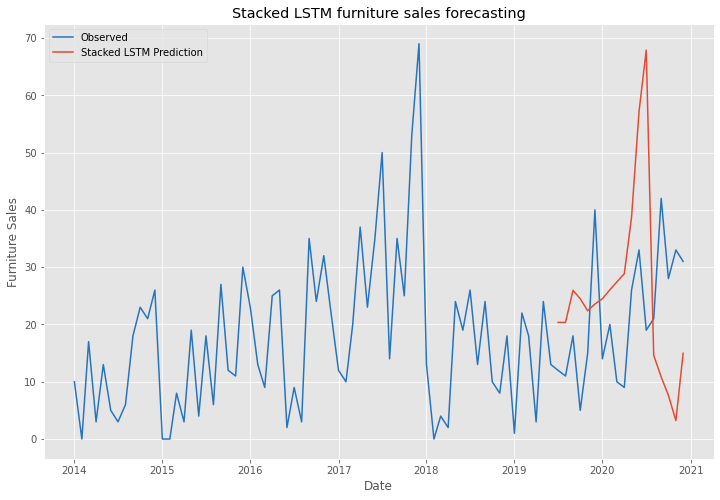

In [49]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df1.index,df1,label="Observed",color='#2574BF')
plt.plot(df1[66:].index,final_stacked2,label="Stacked LSTM Prediction")
plt.title('Stacked LSTM furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()

In [50]:
stacked_lstm= performance(df[-18:],final_stacked2)
stacked_lstm

{'MSE': 744925.1, 'RMSE': 863.09, 'MAPE': 96.49}